# Word2Vec con Negative sampling

Elaboraremos un modelo de Word2Vec utilizando Negative Sampling. El objetivo del negative sampling es simplificar el tiempo de procesamiento del algoritmo de Word2Vec al tomar sólo un número de ejemplos negativos limitados por cada ejemplo positivo.

In [1]:
import numpy as np
from collections import defaultdict, Counter
#from preprocessing import preprocess
from itertools import chain, combinations
import pandas as pd

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.split()]

### Preprocesamiento de corpus

En primer lugar, tomaremos un pequeño corpus. En este caso, el contexto estará determinado por la oración; de aquí obtendremos los pares de entrenamiento. Estos pares son de la forma $(w_i, w_j)$ donde $w_i$ es la palabra objetivo y $w_j$ es el ejemplo positivo, es decir, una palabra que sí aparece en contexto junto con la palabra objetivo.

In [2]:
#Abrimos el documento
corpus = ['el gato es mascota', 'el gato es animal', 'el gato es felino', 
          'el perro es mascota', 'el perro es animal', 'el perro es canino']

#Llamamos la funcion para crear el vocabulario
idx = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(corpus,idx))

print(cads_idx)

[[0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 2, 5], [0, 6, 2, 3], [0, 6, 2, 4], [0, 6, 2, 7]]


In [3]:
#Obtención de los pares de entrenamiento
pairs = []
for cad in cads_idx:
    pairs.append( [(x,y) for x,y in combinations(cad,2)] )
    
pairs = list(chain(*pairs))

pairs = pairs + [(y,x) for x,y in pairs]

## Entrenamiento de la red

Una vez obtenido los pares de entrenamiento, debemos construir la red neuronal para entrenar los embeddings. Para esto, definiremos primero una función para obtener los ejemplos negativos a partir de un subsampleo de las palabras en el corpus determinado por la distribución:

$$p_{NS}(w_k) = \frac{fr(w_k)^\alpha}{\sum_q fr(w_k)^\alpha}$$

### Negative sampling

En base a la distribución $p_{NS}$ obtendremos un número dado de ejemplos negativos. En este caso $\alpha=0.75$ (que es un valor estándar obtenido empíricamente por Mikolov (2013)). Obtenido $K$ ejemplos negativos, además adjuntaremos el ejemplo positivo a los datos.

In [4]:
frecs = Counter(chain(*cads_idx))

#NEGATIVE SAMPLING
def negative_sampling(posit_samp, num_ex=2, a=0.75):
    #Obtención de frecuencias temportales
    temp_frecs = {i:f for i,f in frecs.items() if i != posit_samp}
    
    #Función de partición prob frecuencia ponderada
    N_exp = (np.fromiter(temp_frecs.values(), dtype=float)**a).sum(0)

    #Obtención de distribución de probabilidad
    for k,v in temp_frecs.items():
        temp_frecs[k] = v**a/N_exp

    #Obtención del sampleo de ejemplos negativos
    neg_samp = np.random.choice(list(temp_frecs.keys()), num_ex, replace=False,p=list(temp_frecs.values()))
    #Se añade el ejemplo positivo
    sample = np.append(posit_samp,neg_samp)
    
    return sample

A continuación se presenta un ejemplo: se toma como ejemplo positivo a la palabra "el", y se muestran 3 ejemplos negativos. El resultado se muestra a continuación:

In [5]:
#Diccionario para recuperar la palabra gráfica
wordID = {v:k for k,v in idx.items()}
#Ejemplo de obtención de negative sampling
print( [wordID[w] for w in negative_sampling(idx['el'], num_ex=2)] )

['el', 'perro', 'animal']


### Entrenamiento

Una vez definido el negative sampling, podemos entrenar la red. Ya que en cada ejemplo, no se activarán todos los nodos de salida, sino una muestra aleatoria  de estos, no podemos  usar la función Softmax. Por tanto definiremos la función sigmoide, que será nuestra función de activación en la capa de salida.

In [6]:
#Función sigmoide
sig = lambda x: 1./(1.+np.exp(-x))

Ahora, inicializamos los parámetros de forma aleatoria. En este caso, sólo contamos con los parámetros $U\in\mathbb{R}^{d\times N}$ y $W\in\mathbb{R}^{N\times d}$.

In [7]:
np.random.seed(0)

N = len(idx)
#El número de rasgos que representan cada vector
nn_input_dim = N
#El total de clases que arrojará
output_dim = N

#Dimensiones de los vectores-palabra
dim = 2

#Embedding
U = np.random.randn(dim, N) / np.sqrt(N)

#Capa de salida
W = np.random.randn(N,dim) / np.sqrt(dim)

Entrenamos entonces la red eligiendo un número de iteraciones y un rango de aprendizaje.  En el paso Forward, antes de pasar por la capa de salida, aplicamos negative sampling. De esta forma, sólo trabajaremos con $K$ ejemplos negativos más un ejemplo positivo. Por lo tanto, sólo actualizaremos los vectores renglones de $W$ correspondientes a estos ejemplos.

In [8]:
its = 15
eta = 0.01
for i in range(0,its):
    for ex in pairs:
        #Forward
        #Embedimiento
        u_w = U.T[ex[0]]
            
        #NEGATIVE SAMPLING
        sample = negative_sampling(ex[1], num_ex=3)

        #salida
        a = np.dot(W[sample],u_w)
        
        #Softmax
        f = sig(a) #-np.max(a))

        #Backprop
        #Variable de salida
        y = np.zeros(len(sample))
        y[0] = 1
        d_out = y - f[0]
        
        #Variable de embedding
        d_emb = np.dot(d_out,W[sample])
        
        #Actualizacion de salida
        W[sample] -= eta*np.outer(d_out,u_w)

        #Actualizacion de embedding
        U.T[ex[0]] -= eta*d_emb

### Normalización de embeddings

Un paso extra, per no necesario, es la normalización de los vectores de embeddings. Estos pueden normalizarse a partir de la función $\frac{x-\mu}{\sigma}$ ($\mu$ su media y $\sigma$ la varianza); asimismo, pueden normalizarse como $\frac{x}{||x||}$ ($||x||$ es la norma de $x$). Optamos por esta última opción.

In [9]:
#Obtención de normas
norms = [np.linalg.norm(u) for u in U.T]
#Normalización
U = U/norms
print(U.T)

[[0.99968827 0.02496726]
 [0.99809473 0.06170021]
 [0.99573582 0.09225067]
 [0.99314578 0.11688226]
 [0.99797812 0.06355841]
 [0.99411546 0.10832563]
 [0.9979401  0.06415256]
 [0.99838608 0.05679123]]


## Visualización

Finalmente, visualizamos los vectores de embedding. Para esto definimos una función que los ploteará. Buscamos que palabras similares se encuentren cercanas en el espacio vectorial.

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from operator import itemgetter

#Función de ploteado
def plot_words(Z,ids,mark='o', color='blue'):
    Z = PCA(n_components=2).fit_transform(Z) #PCA no es necesario si la dimensión de los embeddings es 2
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker=mark, c=color)
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

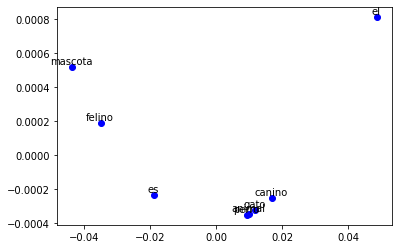

In [11]:
#Etiquetas de las palabras
labels = [w[0] for w in sorted(idx.items(), key=itemgetter(1))]
#Plot de los embeddings
plot_words(U.T, labels)
plt.show()

## Similitud entre palabras

Podemos calcular la  similitud  entre vectores: si asumimos que palabras similares están cercanas en el espacio vectorial, podemos definir una función que nos indique, numéricamente, qué tan cercanas están dos vectores palabra. En este caso, pueden definirse una multitud de funciones de similitud (métricas, distancias). Dos de ellas, quizá las más comúnes, son la distancia euclideana y el coseno.

La distancia euclideana se define como:

$$d(x,y) = [\sum_i (x_i-y_i)^2]^{1/2}$$

Una forma general de definir metricas está dada por:

$$d_p(x,y) = [\sum_i (x_i-y_i)^p]^{1/p}$$

De donde la distancia euclideana es sólo una particularidad. 

Por su parte, el coseno está dado por la función:

$$\cos(x,y) = \frac{x\dot y}{||x|| ||y||}$$

Debe notarse que la distancia euclideana y el coseno no siempre dan los mismos resultados: mientras que la distancia  euclideana se fija en la cercanía entre dos vectores en el espacio euclideao, el coseno se fija en la correlación lineal que guarda un vector con otro.

In [12]:
#Funciones de similitud
cos = lambda u,v: np.dot(u,v)/( np.linalg.norm(u)*np.linalg.norm(v) )
euc = lambda u,v: np.linalg.norm(u-v)

Definida una función de similitud, se puede obtener las palabras más similares dada una palabra de entrada.

In [13]:
word = 'gato'

print('Similitud con la palabra', word)
print('\t Palabra \t euc \t cos \t comb')
vec_word = U.T[idx[word]]
for w,j in idx.items():    
    print('\t',w,'\t',round(euc(vec_word,U.T[j]),4),'\t',round(cos(vec_word,U.T[j]),4),'\t',
          round(euc(vec_word,U.T[j])*cos(vec_word,U.T[j]),4) )
    

Similitud con la palabra gato
	 Palabra 	 euc 	 cos 	 comb
	 el 	 0.0368 	 0.9993 	 0.0367
	 gato 	 0.0 	 1.0 	 0.0
	 es 	 0.0306 	 0.9995 	 0.0306
	 mascota 	 0.0554 	 0.9985 	 0.0553
	 animal 	 0.0019 	 1.0 	 0.0019
	 felino 	 0.0468 	 0.9989 	 0.0467
	 perro 	 0.0025 	 1.0 	 0.0025
	 canino 	 0.0049 	 1.0 	 0.0049


## Composición de vectores

La composición asume que el significado de una unidad lingüística compleja es el resultado de la suma de los significados de sus partes. Por ejemplo, el significado de una oración, como "yo comí ayer" es sólo el resultado de los significados individuales de las palabras "yo", "comí"  y "ayer". Así, si $\phi$ es una función de significado, tenemos que:

$$\phi(w_i \cdot w_j) = \phi(w_i) \oplus \phi(w_j)$$

En este caso $\oplus$ es una función que opera sobre los significados de $w_i$ y  $w_j$ para componerlo en el significado de $w_i\cdot w_j$. De esta forma, dado que los embeddings de palabras representan el  significado de las palabras, podemos operar sobre estos vectores para obtener significados de unidades mayores a aprtir de la composición.

### Composición por suma

Una de las formas más sencillas de realizar la composición es a partir de la suma de vectores. Así, si $\phi(w)$ es el emebedding de una palabra, tenemos que:

$$\phi(w_i \cdot w_j) = \phi(w_i) + \phi(w_j)$$

donde la operación de suma se hace de la forma usual sobre vectores.

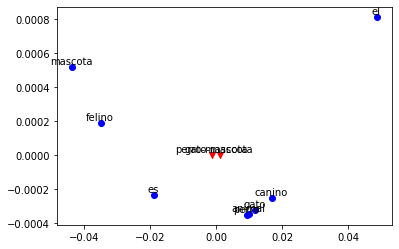

In [17]:
#Composición de vectores
gato_mascota = (U.T[idx['gato']]+U.T[idx['mascota']])
perro_mascota = (U.T[idx['perro']]+U.T[idx['mascota']])

#Concatenar a la matriz
plus_U = np.vstack([ gato_mascota,  perro_mascota])

#Plotear los vectores
plot_words(U.T, labels)
plot_words(plus_U, ['gato-mascota', 'perro-mascota'], mark='v',color='red')
plt.show()

Otras formas simples de realziar composición es a partir del promedio:

$$\phi(w_i \cdot w_j) = \frac{\phi(w_i) + \phi(w_j)}{2}$$

O bien a partir del producto punto a punto (pairwise) también conocido como producto de Hadamard:

$$\phi(w_i \cdot w_j) = \phi(w_i) \odot \phi(w_j)$$

donde $x \odot y = (x_i y_i)_{i=1}$, es decir, el resultado es un vector de igual tamaño cuyas entradas son el producto de las entradas de los vectores $x$ y $y$ en esa posición.

### Composición por transformación

Una forma general de hacer composición es a partir de una tranformación lineal. De igual forma si $\phi(w)$ es el embedding de una palabra, entonces:

$$\phi(w_i \cdot w_j) = T[\phi(w_i); \phi(w_j)]$$

donde $[\phi(w_i);\phi(w_j)]$ es la concatenación de los vectores y $T$ es una tranformación lineal que va de $\mathbb{R}^{2d}$ a $\mathbb{R}^d$. Esta tranformación puede ser aprendida, por ejemplo, por medio de un método de descomposición en valores singulares o bien, por medio de un AutoEncoder.

In [15]:
#Palabras concatenadas
names = []
#Concatenación de los vectores
combs = []
for u,v in combinations(idx.keys(),2):
    combs.append(np.concatenate((U.T[idx[u]],U.T[idx[v]])) )
    names.append((u,v))
    
combs = np.array(combs)

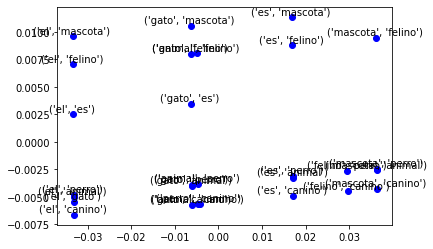

In [16]:
#Estimación de T
evals,evecs = np.linalg.eig(np.dot(combs.T, combs))
T = evecs[:2].T
plot_words(np.dot(combs,T), names)

De forma más compleja, $T$ puede no ser lineal. Para esto, será necesario usar un AutoEncoder.